In [1]:
#from pymatreader import read_mat
import os
os.environ["KERAS_BACKEND"] = "torch"
import numpy as np
import librosa
import scipy
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
import keras
from keras.layers import Conv2D, BatchNormalization, AveragePooling2D, Input, Flatten, Dense, Reshape, SpatialDropout2D, MultiHeadAttention, Conv1D, Dropout
from keras.layers import LayerNormalization, AveragePooling1D
import torch
from keras.losses import CosineSimilarity
from torch.utils.data import Dataset
import tensorflow as tf
torch.set_default_device('cuda')
from sklearn.preprocessing import scale
from torch.utils.data import Dataset, DataLoader
#torch.backends.cudnn.benchmark = True

In [2]:
def correlation(y_true, y_pred, eps = 1e-8):
    vx = y_true - torch.mean(y_true)
    vy = y_pred - torch.mean(y_pred)
    vx = vx.cuda()
    vy = vy.cuda()
    corr = (torch.sum(vx * vy) / (torch.sqrt(torch.sum(vx ** 2)) * torch.sqrt(torch.sum(vy ** 2)) + eps))
    
    return -corr*2

In [3]:
def err(y_true,y_pred):
    vx = y_true[:,0] - torch.mean(y_true[:,0])
    vy = y_pred - torch.mean(y_pred)
    c = torch.nn.CosineSimilarity(dim=0)(vx,vy)
    return -c

In [4]:
def resample_envelope(filename):
    wav,sfreq = librosa.load(filename,sr=44032)
    wav = scipy.signal.resample(wav,4224) 
    wav = np.abs(scipy.signal.hilbert(wav))
    data = np.asarray(wav,np.float64)
    return data

In [5]:
X = np.load('sub1.npy')

In [6]:
stim1 = np.load('stim.npy')
stim2 = np.load('mask.npy')

In [7]:
stim1.shape

(80, 4224)

In [8]:
def create_data(data,train,val,test):
    dtrain = np.hstack([data[i] for i in range(train)]).T
    dval = np.hstack([data[i] for i in range(train,val)]).T
    dtest = np.hstack([data[i] for i in range(val,test)]).T
    return [dtrain,dval,dtest]


In [9]:
[stimtr,stimval,stimts] = create_data(stim1,65,70,80)
[mastr,masval,masts] = create_data(stim2,65,70,80)
[resptr,respval,respts] = create_data(X,65,70,80)

In [10]:
stimtr = stimtr.reshape(-1,1)
stimval = stimval.reshape(-1,1)
stimts = stimts.reshape(-1,1)

mastr = mastr.reshape(-1,1)
masval = masval.reshape(-1,1)
masts = masts.reshape(-1,1)

In [11]:
trsc = StandardScaler()
X_tr = np.expand_dims(trsc.fit_transform(resptr),axis=-1).astype(np.float32)
X_val = np.expand_dims(trsc.transform(respval),axis=-1).astype(np.float32)
X_test = np.expand_dims(trsc.fit_transform(respts),axis=-1).astype(np.float32)

trst = StandardScaler()
y_tr = trst.fit_transform(stimtr).astype(np.float32)
y_val = trst.transform(stimval).astype(np.float32)
y_test = trst.fit_transform(stimts).astype(np.float32)

trsm = StandardScaler()
m_tr = trsm.fit_transform(mastr).astype(np.float32)
m_val = trsm.transform(masval).astype(np.float32)
m_test = trsm.fit_transform(masts).astype(np.float32)

In [12]:
#strain = np.hstack([y_tr,m_tr])
#sval = np.hstack([y_val,m_val])
#stest = np.hstack([y_test,m_test])

In [13]:
#X_tr = np.expand_dims(resptr,axis=-1).astype(np.float32)
#X_val = np.expand_dims(respval,axis=-1).astype(np.float32)
#X_test = np.expand_dims(respts,axis=-1).astype(np.float32)

#strain = np.hstack([stimtr,mastr])
#sval = np.hstack([stimval,masval])
#stest = np.hstack([stimts,masts])

In [14]:
class MyDataset(Dataset):
    def __init__(self, data,labels, window):
        self.data = data
        self.labels = labels
        self.window = window

    def __getitem__(self, index):
        x,y = self.data[index:index+self.window],self.labels[index]
        return x,y

    def __len__(self):
        return len(self.data) - self.window

In [13]:
train_dataset = MyDataset(X_tr,y_tr,64)
val_dataset = MyDataset(X_val,y_val,64)
test_dataset = MyDataset(X_test,y_test,64)
train_dataloader = DataLoader(train_dataset,batch_size=256,shuffle=False,drop_last=True)
val_dataloader = DataLoader(val_dataset,batch_size=256,shuffle=False,drop_last=True)
test_dataloader = DataLoader(test_dataset,batch_size=256,shuffle=False,drop_last=True)


In [37]:
f,p = next(iter(train_dataloader))
print(f.shape)

torch.Size([128, 64, 66, 1])


In [14]:
train_dataset = keras.utils.timeseries_dataset_from_array(X_tr,y_tr,sequence_length=64,batch_size=64,shuffle=True)
val_dataset = keras.utils.timeseries_dataset_from_array(X_val,y_val,sequence_length=64,batch_size=64,shuffle=True)
test_dataset = keras.utils.timeseries_dataset_from_array(X_test,y_test,sequence_length=64,batch_size=64,shuffle=False)

In [33]:
#train_dataset = keras.utils.timeseries_dataset_from_array(X_tr,strain,sequence_length=96,batch_size=64,shuffle=True)
#val_dataset = keras.utils.timeseries_dataset_from_array(X_val,sval,sequence_length=96,batch_size=64,shuffle=True)
#test_dataset = keras.utils.timeseries_dataset_from_array(X_test,stest,sequence_length=96,batch_size=64,shuffle=True)

In [15]:
def create_model(input_shape):
    inp = Input(input_shape)
    
    out1 = Conv2D(256,(3,3),padding="same",activation="elu")(inp)
    #out1 = LayerNormalization()(out1)
    out2 = SpatialDropout2D(0.2)(out1)
    out2 = AveragePooling2D((2,2))(out2)
    
    bn = BatchNormalization()(out2)

    out3 = Conv2D(128,(3,3),padding="same",activation="elu")(bn)
    #out3 = LayerNormalization()(out3)
    out4 = SpatialDropout2D(0.4)(out3)
    out4 = AveragePooling2D((2,2))(out4)
    bn2 = BatchNormalization()(out4)

    out5 = Conv2D(64,(5,5),padding="same",activation="elu")(bn2)
    #out5 = LayerNormalization()(out5)
    #out6 = SpatialDropout2D(0.2)(out5)
    out6 = AveragePooling2D((2,2))(out5)
    bn3 = BatchNormalization()(out6)

    out7 = Conv2D(32,(3,3),padding="same",activation="elu")(bn3)
    #out7 = LayerNormalization()(out7)
    out8 = SpatialDropout2D(0.4)(out7)
    out8 = AveragePooling2D((2,2))(out8)
    bn4 = BatchNormalization()(out8)

    #bn4 = Conv2D(16,(2,2),padding="valid",activation="elu")(bn4)

    out9 = AveragePooling2D((2,2))(bn4)

    flat = Flatten()(out9)
    #flat = Dropout(0.2)(flat)

    #out = Dense(32,"relu")(flat)
    out = Dense(1)(flat)

    model = keras.Model(inp,out)
    
    return model
    
    

In [16]:
model = create_model((64,66,1))
#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to('cuda')

<Functional name=functional_1, built=True>

In [17]:
callback = keras.callbacks.EarlyStopping(monitor='loss',patience=3)
cpk = keras.callbacks.ModelCheckpoint('best_model.keras',monitor='val_loss',save_best_only=True,mode="min")

In [18]:
#optimizer = keras.optimizers.Nadam(learning_rate = 0.001,weight_decay=1e-8)
model.compile(optimizer="Nadam",loss="mse")

In [19]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 64, 66, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 64, 66, 256)         │           2,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ spatial_dropout2d (SpatialDropout2D) │ (None, 64, 66, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d (AveragePooling2D) │ (None, 32, 33, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 32, 33, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 32, 33, 128)         │         295,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ spatial_dropout2d_1                  │ (None, 32, 33, 128)         │               0 │
│ (SpatialDropout2D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d_1                  │ (None, 16, 16, 128)         │               0 │
│ (AveragePooling2D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 16, 16, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 16, 16, 64)          │         204,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d_2                  │ (None, 8, 8, 64)            │               0 │
│ (AveragePooling2D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 8, 8, 64)            │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 8, 8, 32)            │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ spatial_dropout2d_2                  │ (None, 8, 8, 32)            │               0 │
│ (SpatialDropout2D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d_3                  │ (None, 4, 4, 32)            │               0 │
│ (AveragePooling2D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 4, 4, 32)            │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d_4                  │ (None, 2, 2, 32)            │              

 Total params: 522,977 (1.99 MB)

 Trainable params: 522,017 (1.99 MB)

 Non-trainable params: 960 (3.75 KB)

In [ ]:
model.fit(train_dataset,epochs=20,validation_data=val_dataset,callbacks=[callback,cpk])

Epoch 1/20
4290/4290 ━━━━━━━━━━━━━━━━━━━━ 538s 125ms/step - loss: 1.0938 - val_loss: 1.0886
Epoch 2/20
4290/4290 ━━━━━━━━━━━━━━━━━━━━ 524s 122ms/step - loss: 1.0010 - val_loss: 1.0901
Epoch 3/20
2598/4290 ━━━━━━━━━━━━━━━━━━━━ 3:21 119ms/step - loss: 0.9957

In [ ]:
model.save("model.keras")

In [24]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Attention and Normalization
    x = MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(inputs, inputs)
    x = Dropout(dropout)(x)
    x = LayerNormalization(epsilon=1e-6)(x)
    res = x + inputs

    # Feed Forward Part
    x = Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(res)
    x = Dropout(dropout)(x)
    x = Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    x = LayerNormalization(epsilon=1e-6)(x)
    return x + res


In [28]:
def build_model(input_shape,head_size,num_heads,ff_dim,num_transformer_blocks,mlp_units,dropout=0,mlp_dropout=0):
    inputs = Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    #x = GlobalAveragePooling1D(data_format="channels_last")(x)
    x = AveragePooling1D(4)(x)
    x = Flatten()(x)
    for dim in mlp_units:
        x = Dense(dim, activation="relu")(x)
        x = Dropout(mlp_dropout)(x)
    outputs = Dense(1)(x)
    return keras.Model(inputs, outputs)


In [29]:
model = build_model((64,66),head_size=256,num_heads=4,ff_dim=4,num_transformer_blocks=4,mlp_units=[128],mlp_dropout=0.4,dropout=0.25)

In [31]:
model.summary()
model.cuda()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)    │ (None, 64, 66)            │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ multi_head_attention_13       │ (None, 64, 66)            │         273,474 │ input_layer_4[0][0],       │
│ (MultiHeadAttention)          │                           │                 │ input_layer_4[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_42 (Dropout)          │ (None, 64, 66)            │               0 │ multi_head_attention_13[0… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ layer_normalization_25        │ (None, 64, 66)            │             132 │ dropout_42[0][0]           │
│ (LayerNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ add_25 (Add)                  │ (None, 64, 66)            │               0 │ layer_normalization_25[0]… │
│                               │                           │                 │ input_layer_4[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1d_25 (Conv1D)            │ (None, 64, 4)             │             268 │ add_25[0][0]               │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_43 (Dropout)          │ (None, 64, 4)             │               0 │ conv1d_25[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1d_26 (Conv1D)            │ (None, 64, 66)            │             330 │ dropout_43[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ layer_normalization_26        │ (None, 64, 66)            │             132 │ conv1d_26[0][0]            │
│ (LayerNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ add_26 (Add)                  │ (None, 64, 66)            │               0 │ layer_normalization_26[0]… │
│                               │                           │                 │ add_25[0][0]               │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ multi_head_attention_14       │ (None, 64, 66)            │         273,474 │ add_26[0][0], add_26[0][0] │
│ (MultiHeadAttention)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_45 (Dropout)          │ (None, 64, 66)            │               0 │ multi_head_attention_14[0… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ layer_normalization_27        │ (None, 64, 66)            │             132 │ dropout_45[0][0]           │
│ (LayerNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ add_27 (Add)                  │ (None, 64, 66)            │               

 Total params: 1,232,769 (4.70 MB)

 Trainable params: 1,232,769 (4.70 MB)

 Non-trainable params: 0 (0.00 B)

<Functional name=functional_5, built=True>

In [32]:
#optimizer = keras.optimizers.Nadam(learning_rate = 0.01,weight_decay=1e-8)
model.compile(optimizer="Adam",loss=correlation)

In [33]:
model.fit(train_dataset,epochs=5,validation_data=val_dataset)

Epoch 1/5
 204/2145 ━━━━━━━━━━━━━━━━━━━━ 8:18 257ms/step - loss: -0.0154

KeyboardInterrupt: 

In [130]:
y_test.shape

(42240, 1)

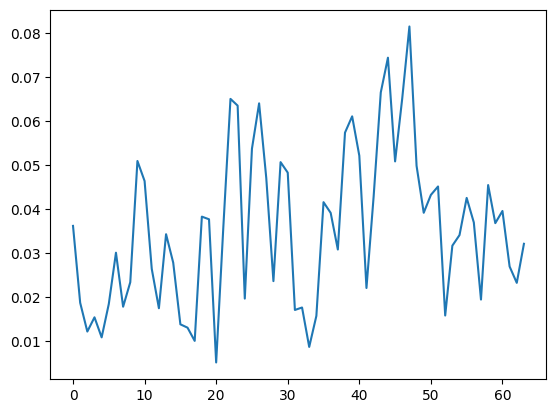

In [131]:
plt.plot(attn[1])

In [132]:
from scipy.stats import pearsonr
total = 0
for i in range(len(pred)):
    p = np.squeeze(pred[i])
    a = np.squeeze(attn[i])
    m = np.squeeze(maskk[i])
    peara = pearsonr(p,a)
    pearm = pearsonr(p,m)
    if peara>pearm:
        total+=1



In [134]:
total/len(pred)

0.5022761760242792

In [147]:
pearsonr(p,a)

PearsonRResult(statistic=-0.46965448175162616, pvalue=9.032673009754197e-05)

In [151]:
p = torch.tensor(p)
a = torch.tensor(a)

In [159]:
torch.corrcoef(m)[0,1]

tensor(-0.4697)

In [154]:
m = torch.vstack([p,a])

In [27]:
len(m_test)/128

330.0

In [41]:
from scipy.stats import pearsonr
total = 0
i = 0
for inp,target in test_dataset:
    pred = np.squeeze(model.predict(inp))
    a = np.squeeze(target)
    maskk = np.squeeze(m_tr[i:i+128])
    pa = pearsonr(pred,a)
    pm = pearsonr(pred,maskk)
    print(pm)
    i+=1
    if np.abs(pa.statistic)>np.abs(pm.statistic):
        total+=1
    

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step 
PearsonRResult(statistic=0.06990661542568175, pvalue=0.4329788535765721)
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
PearsonRResult(statistic=-0.23333135948942543, pvalue=0.008033976785629069)
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
PearsonRResult(statistic=0.06416856961887332, pvalue=0.4717683324769163)
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
PearsonRResult(statistic=-0.16245368211297434, pvalue=0.06693444719806495)
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
PearsonRResult(statistic=0.11611058749690151, pvalue=0.19183358835787315)
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
PearsonRResult(statistic=0.04663656534784128, pvalue=0.6011544221494036)
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
PearsonRResult(statistic=0.10744025692338771, pvalue=0.22738551005541113)
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
PearsonRResult(statistic=0.017487513074116653, pvalue=0.8446706304430501)
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
PearsonRResult(statistic=-0.08926409435807206, pvalue=0.316342195

ValueError: x and y must have the same length.

In [48]:
model.evaluate(train_dataset)

2145/2145 ━━━━━━━━━━━━━━━━━━━━ 83s 39ms/step - loss: -0.0135


-0.026594841852784157

In [37]:
y_test[0]

array([4.751173], dtype=float32)

In [27]:
total

67

In [29]:
for i,j in train_dataset:
    print(i.shape)
    break

InvalidArgumentError: {{function_node __wrapped__IteratorGetNext_output_types_2_device_/job:localhost/replica:0/task:0/device:CPU:0}} TypeError: too many positional arguments
Traceback (most recent call last):

  File "C:\Users\gauta\anaconda3\envs\keras-jax\lib\site-packages\tensorflow\python\ops\script_ops.py", line 268, in __call__
    return func(device, token, args)

  File "C:\Users\gauta\anaconda3\envs\keras-jax\lib\site-packages\tensorflow\python\ops\script_ops.py", line 146, in __call__
    outputs = self._call(device, args)

  File "C:\Users\gauta\anaconda3\envs\keras-jax\lib\site-packages\tensorflow\python\ops\script_ops.py", line 153, in _call
    ret = self._func(*args)

  File "C:\Users\gauta\anaconda3\envs\keras-jax\lib\site-packages\tensorflow\python\autograph\impl\api.py", line 643, in wrapper
    return func(*args, **kwargs)

  File "C:\Users\gauta\anaconda3\envs\keras-jax\lib\site-packages\sklearn\utils\_param_validation.py", line 191, in wrapper
    params = func_sig.bind(*args, **kwargs)

  File "C:\Users\gauta\anaconda3\envs\keras-jax\lib\inspect.py", line 3186, in bind
    return self._bind(args, kwargs)

  File "C:\Users\gauta\anaconda3\envs\keras-jax\lib\inspect.py", line 3112, in _bind
    raise TypeError(

TypeError: too many positional arguments


	 [[{{node EagerPyFunc}}]] [Op:IteratorGetNext] name: 